In [28]:
import os # File/directory operations
import ntpath # File/directory operations
import imageio as imio # Reading images
import pandas as pd # Data manipulations
import numpy as np # Data manipulations
from skimage import data # Image operations
from skimage.color import rgb2gray # RGB image to grey
from skimage.filters import threshold_otsu # Binary mask
import matplotlib.pyplot as plt # for visualisation
from shutil import copyfile
import errno

In [20]:
dataPaths = {'Data':os.path.abspath(os.path.join('Data')),
             'InputImage':os.path.abspath(os.path.join('Data','Images')),
             'InputAnnot':os.path.abspath(os.path.join('Data','Annotations')),                       
             'OutputImage':os.path.abspath(os.path.join('Output','Images')),
             'OutputAnnot':os.path.abspath(os.path.join('Output','Annotations'))}

In [24]:
def copyFileToDir(file, path):
        dest = path+'\\'
        dest = dest+path_leaf(file)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        copyfile(file, dest)
        
def get_files_in_dir(dir):
    """This function will return a list of fi les in the given dir"""
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(dir):
        for file in f:
            files.append(os.path.join(r, file))
    return files

def path_leaf(path):
    """This function returns the file name from a file path"""
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def remove_file_ext(fileName):
    """This function removes the file extension"""
    return os.path.splitext(fileName)[0]

def validate_keys(imFileDict, anFileDict):
    """This function validates that the input files have been setup correctly"""
    valid = True
    for key in imFileDict.keys():
        if key not in anFileDict:
            print(key)
            valid = False
    for key in anFileDict.keys():
        if key not in imFileDict:
            print(key)
            valid = False
    return valid

def load_image(path):
    return np.array(imio.imread(path))

def get_image_alpha(image):
    return image[:,:,3]

def get_mask_of_value(image, value=1, mask_value = 1):
    image = image > threshold_otsu(image)
    mask = np.array(np.ma.masked_where(image ==value,image))
    maskOut = np.zeros(image.shape,np.uint8)
    maskVals = mask == value
    maskOut[maskVals] = mask_value
    return maskOut    

In [25]:
# Setup the file names and setup colleralations
imFiles = {}
imDirs = get_files_in_dir(dataPaths['InputImage'])
for file in imDirs:
    imFiles[str(remove_file_ext(path_leaf(file)).split('.')[0])] = file

anFiles = {}
anDirs = get_files_in_dir(dataPaths['InputAnnot'])
for file in anDirs:
    key = str(remove_file_ext(path_leaf(file)).split('_')[0])
    if key in anFiles:
        anFiles[key].append(file)
    else:
        anFiles[key] = []
        anFiles[key].append(file)

if (not validate_keys(imFiles, anFiles)):
    raise Exception('Image validation failed', 'please check if input files are in correct format')

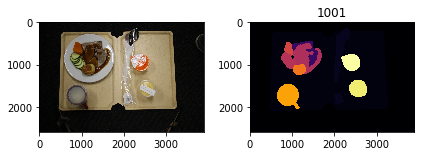

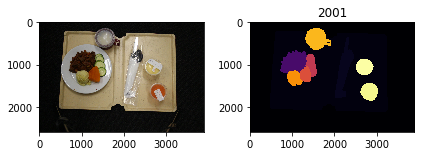

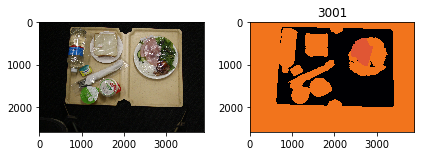

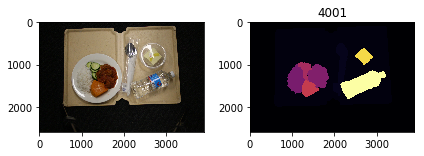

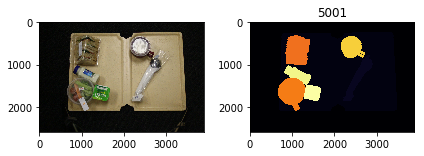

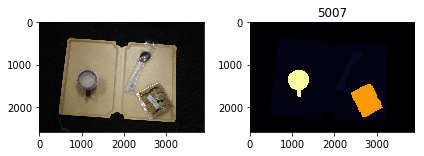

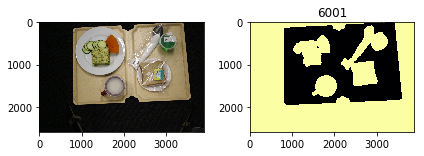

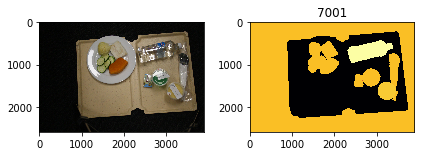

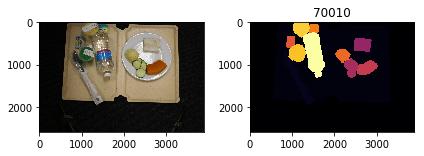

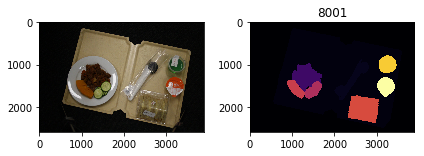

In [33]:
classes = pd.read_csv(dataPaths['Data']+'\\classes.csv')
unique = {}
for key in imFiles.keys():
    img = load_image(imFiles[key])
    mask = np.zeros(rgb2gray(img).shape,np.uint8)
    for an in anFiles[key]:
        cls = str(remove_file_ext(path_leaf(an)).split('_')[-1]).lower()
        unique[cls] = 1
        #print(cls)
        id = classes.loc[classes['_class'] == cls, '_id'].values[0]
        #print(id)
        classMask = get_mask_of_value(get_image_alpha(load_image(an)))
        maskVals = classMask == 1
        mask[maskVals] = id
    
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    plt.title(key)
    ax[0].imshow(img)
    ax[1].imshow(mask,cmap='inferno')
    plt.tight_layout()
    plt.show()
    
    copyFileToDir(imFiles[key],dataPaths['OutputImage'])
    imio.imwrite(dataPaths['OutputAnnot']+'\\' + str(key)+ '.png',mask)

In [16]:
for i in sorted (unique.keys()) :  
     print(i, end = "\n") 

background
bakedfish
bean
beefmexicanmeatballs
beeftomatocasserole
boiledrice
bread
cannedfruit
creamedpotato
cucumber
custard
cutlery
gravy
ham
jacketpotato
jelly
juice
leaf
lemonsponge
margarine
milk
orangejuice
pumpkin
roastlamb
sandwich
sidesalad
soup
spinachandpumpkinrisotto
tartaresauce
tomato
tray
vanillayogurt
water
zucchini
